In [1]:
from scripts_fermions.operators import Hamiltonian, Boost, measure_local_observables
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import yastn
import yastn.tn.mps as mps

In [2]:
g = 1
t, v, Q = 0, 1, 0
N = 256
D = 128
a = 0.125
#
m = 0.0
#
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt, m=m), allow_pickle=True).item()


In [3]:
H = Hamiltonian(N, m, g, t, a, v, Q, ops)
K = Boost(N, m, g, a, ops)

psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

print(E_ex)
print(E_gs)
print(E_ex - E_gs)

-644.461875930207
-645.0617360234714
0.5998600932643967


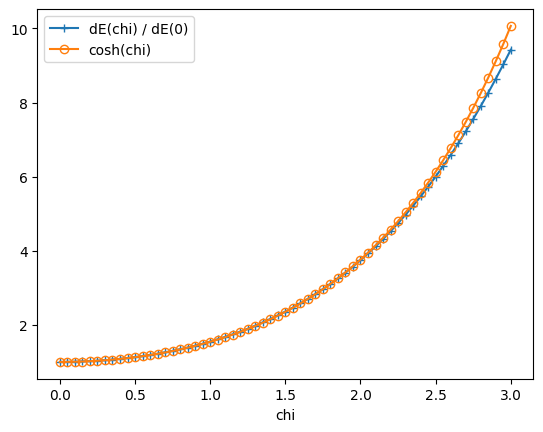

In [4]:
chis = d_boost['chis']
dE = np.array(d_boost['energy']).real - E_gs
plt.plot(chis, dE / dE[0], '-+', label='dE(chi) / dE(0)')
plt.plot(chis, np.cosh(chis), '-o', fillstyle='none', label='cosh(chi)')
plt.xlabel("chi")
plt.legend()


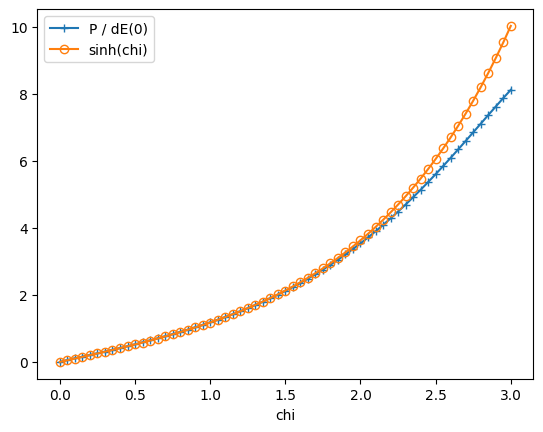

In [5]:
chis = d_boost['chis']
Ps = np.sum(np.array(d_boost['T01']).real, axis=1) * a
plt.plot(chis, Ps / dE[0], '-+', label='P / dE(0)')
plt.plot(chis, np.sinh(chis), '-o', fillstyle='none', label='sinh(chi)')
plt.xlabel("chi")
plt.legend()


In [6]:
egs = {}
egs['T00'], egs['T11'], egs['T01'], egs['j0'], egs['j1'], egs['nu'], egs['Ln'] = measure_local_observables(psi_gs, 0, a, g, m, 1, 0, ops)

In [7]:
def plot_dist(val, subtract_gs=True):
    cm = plt.cm.jet
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=2)

    for ii, chi in enumerate(d_boost['chis']):
        if chi <= 2:
            y = d_boost[val][ii]
            if subtract_gs:
                y = y - egs[val]
            plt.plot(y, color=cm(normalize(chi)))


    # setup the normalization and the colormap

    # setup the colorbar
    scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=cm)
    scalarmappaple.set_array([])
    plt.colorbar(scalarmappaple, ax=plt.gca(), label='chi')
    plt.title(val)


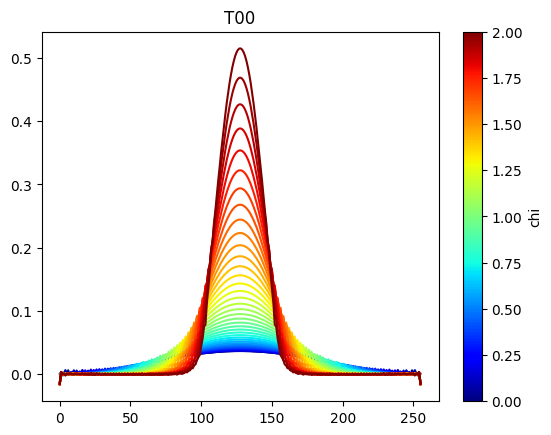

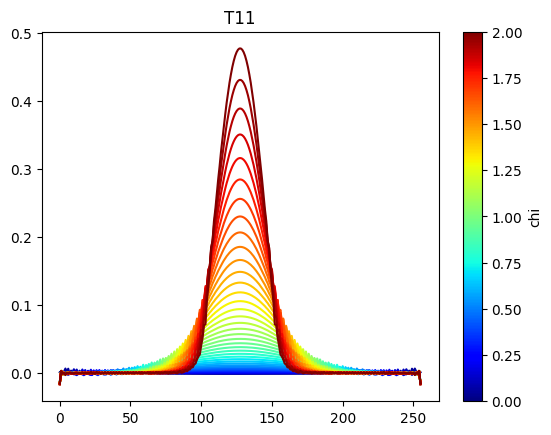

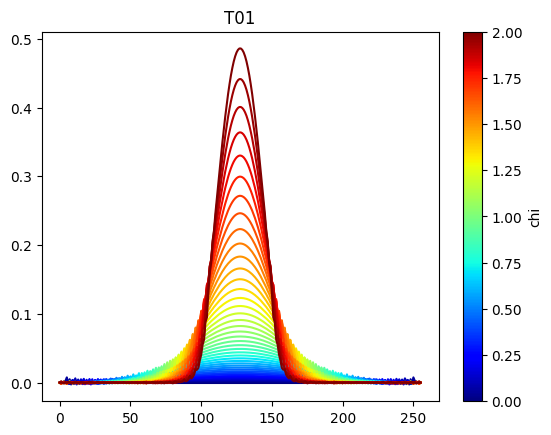

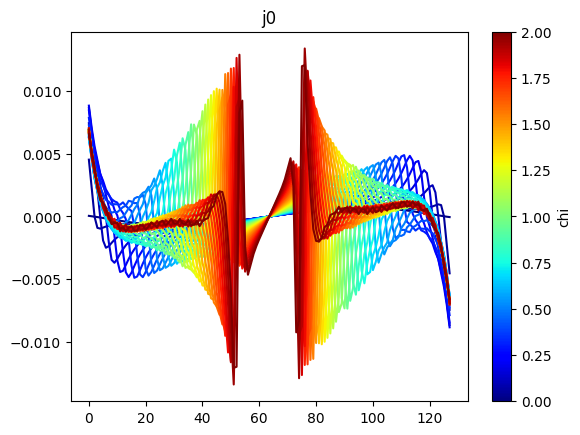

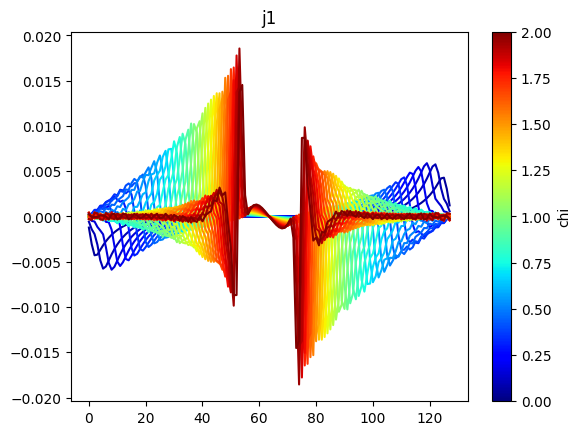

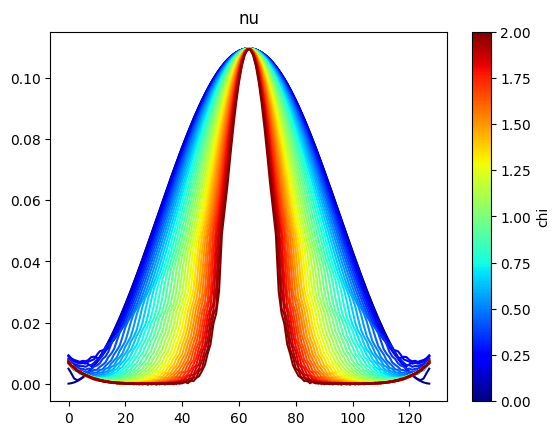

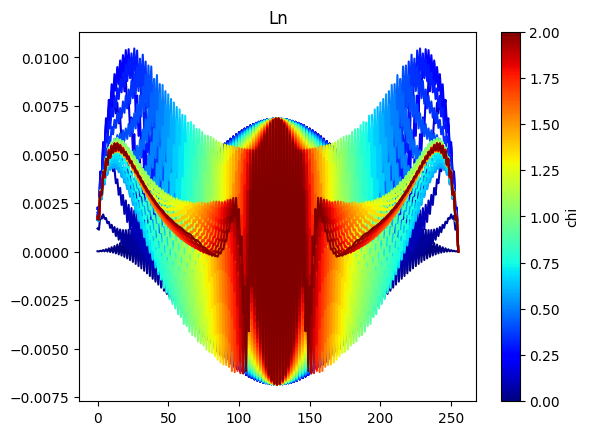

In [8]:
for val in ['T00', 'T11', 'T01', 'j0', 'j1', 'nu', 'Ln']:
    plot_dist(val, subtract_gs=True)
    plt.show()


In [9]:
def exc(N, ops=None):
    from scripts_fermions.operators import S, s2i

    I, cp, cm, d = ops.I(), ops.cp(), ops.c(), ops.n()
    sites = list(range(N))
    terms =  [mps.Hterm( 1 / np.sqrt(N), [S(n + 1), S(n)], [cp, cm]) for n in sites[:-1]]
    terms += [mps.Hterm( 1 / np.sqrt(N), [S(n), S(n + 1)], [cp, cm]) for n in sites[:-1]]

    terms = [mps.Hterm(v, tuple(s2i(k) for k in p), o) for v, p, o in terms]
    H = mps.generate_mpo(I, terms, N=N)
    return H

Hex = exc(N, ops)

In [10]:
psi_ex0 = Hex @ psi_gs
psi_ex0 = psi_ex0 / psi_ex0.norm()

In [11]:
eex = {}
eex['T00'], eex['T11'], eex['T01'], eex['j0'], eex['j1'], eex['nu'], eex['Ln'] = measure_local_observables(psi_ex0, 0, a, g, m, 1, 0, ops)

(0.0, 0.1)

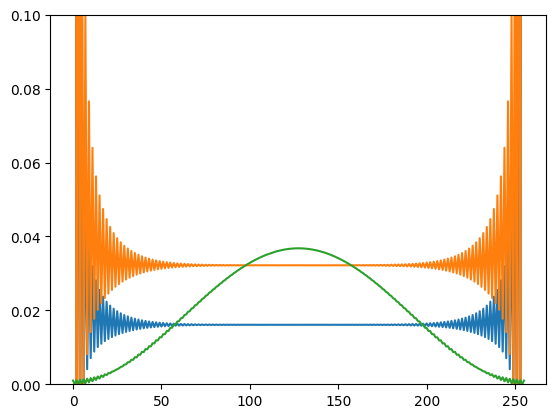

In [22]:
plt.plot(eex['T00'] - egs['T00'])
plt.plot((eex['T00'] - egs['T00'])*2)
plt.plot(d_boost['T00'][0] - egs['T00'])
plt.ylim([0, 0.1])

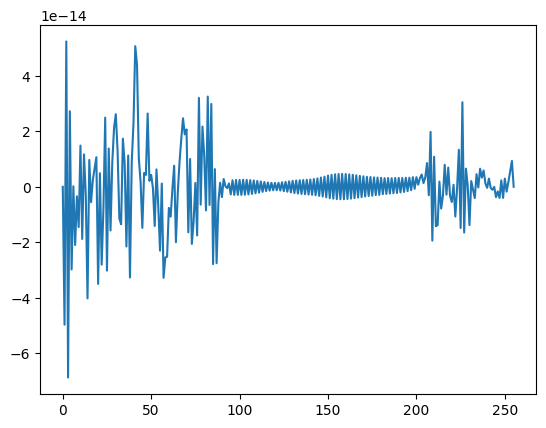

In [23]:
plt.plot(eex['T01'] - egs['T01'])

In [14]:

E_ex2 = mps.vdot(psi_ex0, H, psi_ex0).real


In [15]:
print(E_ex2 - E_gs)
print(E_ex - E_gs)
print((E_ex2 - E_gs) / (E_ex - E_gs))


0.9998781544859412
0.5998600932643967
1.666852263908196


In [16]:
print(E_ex2 - E_gs)

print(E_ex - E_gs)


0.9998781544859412
0.5998600932643967


In [17]:
abs(mps.vdot(psi_ex, psi_ex0)) ** 2

np.float64(0.7140788090027237)

In [18]:
2.346977911378076 / 1.5194084497672975

1.5446655649029222

In [19]:
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>